In [1]:
import os
import glob
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from iminuit import Minuit
import scipy as sp
import scipy.stats
import scipy.constants
from scipy.interpolate import interp1d
import copy

from picca import wedgize

#%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
#plt.rc('text',usetex=True)

## __Which mocks__

In [2]:
### Get mocks
mock = {}
mock['nbReal'] = 10
mock['team'] = 'london'
mock['mock_ver'] = 'v6.0/v6.0.<*>'
mock['quick_ver'] = 'eboss-raw'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']#+'/lybforest/'
mock['picca_all'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/v6.0/global/'+mock['quick_ver']+'/stack/'#'/lybforest/'+
mock['input_nz_QSO'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Nz_qso_130618_2_colore1_hZs.txt'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [3]:
### Get data products
data = {}
data['forest'] = 'LYA'
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v3_1.fits'
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
#data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/'
data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis/'
data['picca_delta'] = data['picca']+'/Delta_'+data['forest']+'/Delta/'
data['picca_delta_attributes'] = data['picca']+'/Delta_'+data['forest']+'/Log/delta_attributes.fits.gz'
data['picca_cf1d'] = data['picca']+'/Correlations_cf1d/cf1d_'+data['forest']+'.fits.gz'

Redshift bins

In [4]:
#zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10','0:10']
zint = ['0:10']

## __Look at fit results__

In [5]:
toPlot = {}

In [6]:
### Mocks
for idx in range(mock['nbReal']):
    path = mock['picca'].replace('<*>',str(idx))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            toPlot['{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)] = {
                'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
                'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
                'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
                'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

In [7]:
### Mocks stacked
path = mock['picca_all']
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in ['cf','xcf','cfxcf','allCombined']:
        toPlot['{}-Mock-{}-z-{}-{}'.format('all',cor,zmin,zmax)] = {
            'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
            'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
            'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
            'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

Load the fit results

In [8]:
for name,paths in sorted(toPlot.items()):

    ### Exist?
    if not os.path.isfile(os.path.expandvars(paths['FIT'])):
        print(' WARNING: does not exist ', paths['FIT'])
        continue

    ### Covar matrix is possitive definite
    if (not 'cfxcf' in toPlot[name]['CORR']) and (not 'allCombined' in toPlot[name]['CORR']):
        h = fitsio.FITS(toPlot[name]['CORR'])
        try:
            sp.linalg.cholesky(h[1]['CO'][:])
            print('ok: ', name)
        except sp.linalg.LinAlgError:
            print('not ok', name)
            #continue
        h.close()
    try:
        f = h5py.File(os.path.expandvars(paths['FIT']),'r')
        toPlot[name]['FIT_RES'] = {}
        toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
        for k in list(f['best fit'].attrs['list of free pars']):
            toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
        for k in list(f['best fit'].attrs['list of fixed pars']):
            toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
        for k in ['fval','is_valid','npar','ndata']:
            toPlot[name]['FIT_RES'][k] = f['best fit'].attrs[k]
        if not toPlot[name]['FIT_RES']['is_valid']:
            print(toPlot[name]['FIT_RES']['is_valid'])
        p = 1.-sp.stats.chi2.cdf(toPlot[name]['FIT_RES']['fval'],toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar'])
        toPlot[name]['FIT_RES']['proba'] = p
        f.close()
    except:
        print('does not exist {}'.format(paths['FIT']))
        continue

ok:  0-Mock-cf-z-0-10
not ok 0-Mock-xcf-z-0-10
ok:  1-Mock-xcf-z-0-10
ok:  2-Mock-xcf-z-0-10
ok:  6-Mock-xcf-z-0-10
ok:  7-Mock-xcf-z-0-10
ok:  8-Mock-xcf-z-0-10


### Chi2 and probability as a function of mock index

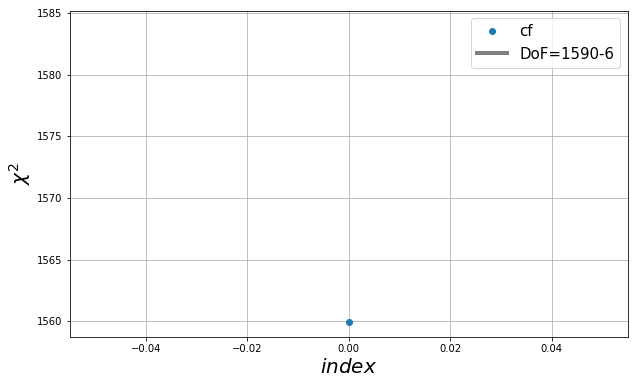

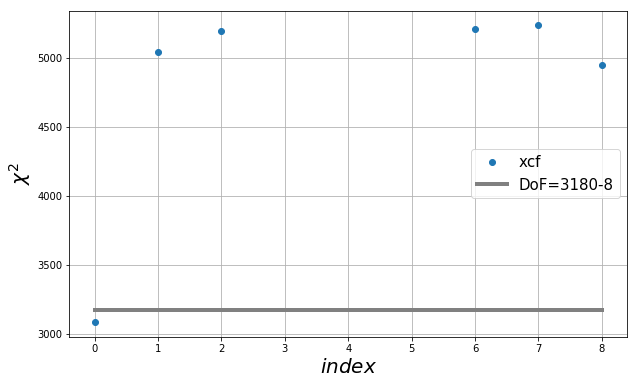

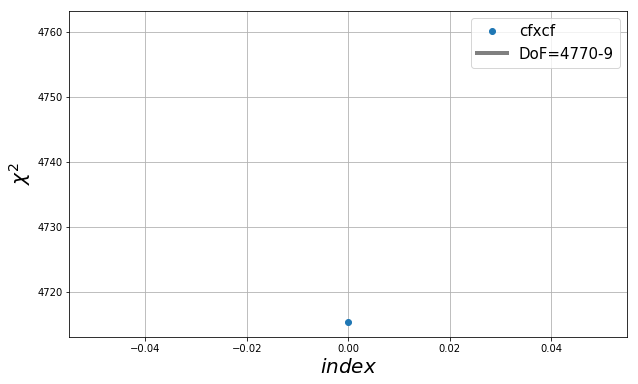

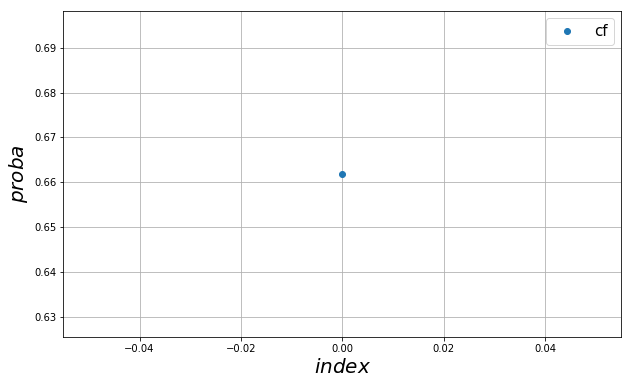

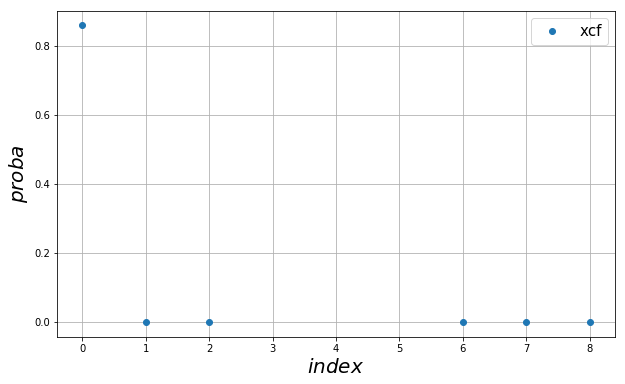

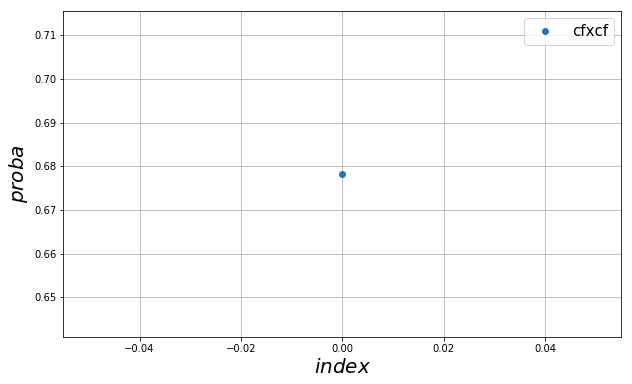

In [9]:
latexnameProba = {'fval':'\chi^{2}',
             'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf','allCombined']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yyy[w],fmt='o',label=cor)
            if p=='fval':
                if (exp[w]==exp[w][0]).sum()!=exp[w].size:
                    print(exp[w])
                plt.errorbar(xxx[w],exp[w],linewidth=4,color='grey',label='DoF={}-{}'.format(int(ndata[w][0]),int(npar[w][0])))

            plt.xlabel(r'$index$')
            plt.ylabel(r'$'+latexnameProba[p]+'$')
            plt.legend(fontsize=15)
            plt.grid()
            plt.show()

### Histogram of Chi2 and probability

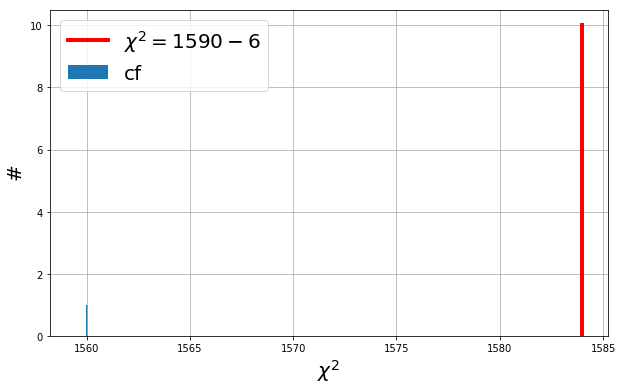

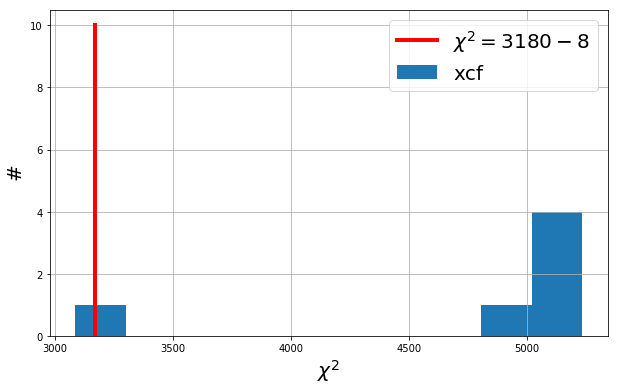

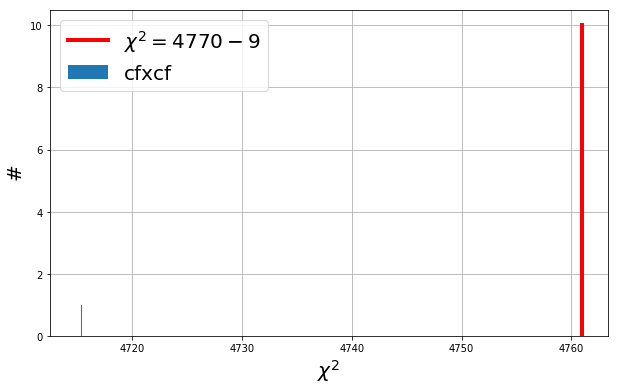

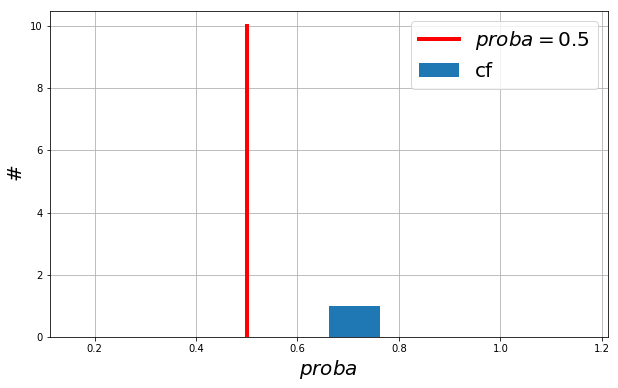

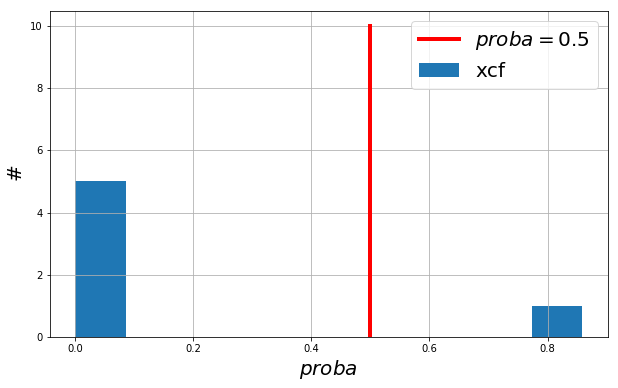

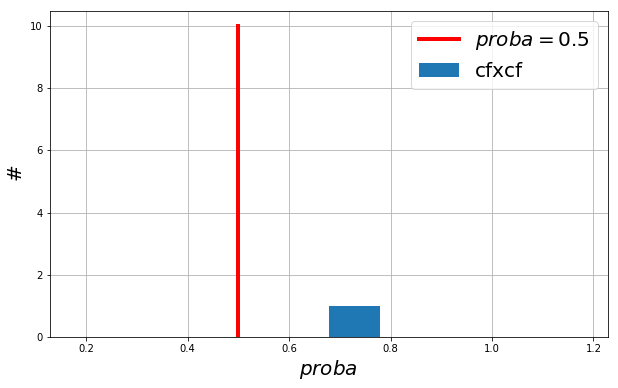

In [10]:
latexnameProba = {'fval':'\chi^{2}',
                'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf','allCombined']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,label=cor)
            if p=='fval':
                plt.plot([exp[0],exp[0]],[0.,10.],color='red',label=r'$\chi^{2}='+str(int(ndata[0]))+'-'+str(int(npar[0]))+'$')
            elif p=='proba':
                plt.plot([0.5,0.5],[0.,10.],color='red',label=r'$proba={}$'.format(0.5))
            plt.xlabel(r'$'+latexnameProba[p]+'$')
            plt.ylabel(r'$\#$')
            plt.legend()
            plt.grid()
            plt.show()

### Parameters

In [11]:
omega_M_0 = 0.3147
def alpha(z,a0,a1,zeff=2.30):
    evol = a0*((1.+z)/(1.+zeff))**a1
    return evol
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0=0.3147):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

In [12]:
biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
fromztobiasQso = interp1d(biasCoLoRe[:,0],betaCoLoRe)
print(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF'], fromztobiasQso(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF']))

2.304313861574754 0.2587331016570988


In [13]:
latexname = {'ap':'\\alpha_{\parallel}',
             'at':'\\alpha_{\perp}',
             'bias_eta_LYA' : 'b_{\\eta,\mathrm{Ly}\\alpha}',
             'beta_LYA' : '\\beta_{\mathrm{Ly}\\alpha}',
             'beta_QSO' : '\\beta_{\mathrm{qso}}',
             'sigma_velo_lorentz_QSO':'\sigma_{v}\,[\mathrm{h^{-1}\,Mpc}]',
             'drp_QSO':'\Delta r_{\parallel}\,[\mathrm{h^{-1}\,Mpc}]',
             #'par binsize cf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize cf_z_0_10-exp': 'R_{\\perp}',
             #'par binsize xcf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize xcf_z_0_10-exp': 'R_{\\perp}',
             'par_sigma_smooth': 'par-sigma-smooth',
             'per_sigma_smooth': 'per-sigma-smooth',
            }
expected = {'ap':1.,
             'at':1.,
             'bias_eta_LYA' : None,
             'beta_LYA' : None,
             'beta_QSO' : fromztobiasQso(toPlot['0-Mock-xcf-z-0-10']['FIT_RES']['ZEFF']),
             'sigma_velo_lorentz_QSO':None,
             'drp_QSO':0.,
             #'par binsize cf_z_0_10-exp': None,
             #'per binsize cf_z_0_10-exp': None,
             #'par binsize xcf_z_0_10-exp': None,
             #'per binsize xcf_z_0_10-exp': None,
             'par_sigma_smooth': None,
             'per_sigma_smooth': None,
            }

### The parameters as a function of mock index

cf: <ap> = 1.0284785121703008 +/- 0.0 (<0.02829676848186169>, 0.02829676848186169)
xcf: <ap> = 0.847935378175548 +/- 0.1550334848965662 (<0.017752250762609955>, 0.007247326025721324)
cfxcf: <ap> = 1.0428275312260937 +/- 0.0 (<0.01930830082948798>, 0.01930830082948798)


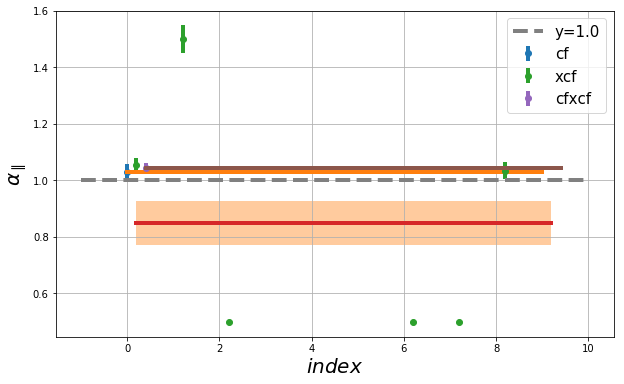

cf: <at> = 1.012244214769246 +/- 0.0 (<0.033960544315102426>, 0.033960544315102426)
xcf: <at> = 0.9187506643839697 +/- 0.08933713013720082 (<0.03608125036879634>, 0.014730108780859735)
cfxcf: <at> = 1.0072072585255845 +/- 0.0 (<0.017909764500449787>, 0.017909764500449787)


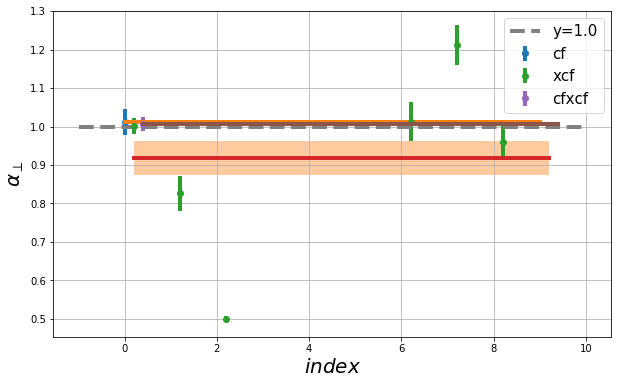

cf: <bias_eta_LYA> = -0.15604323063559739 +/- 0.0 (<0.0019912667364278907>, 0.0019912667364278907)
xcf: <bias_eta_LYA> = -0.27036615693670524 +/- 0.025048825314499208 (<0.0034993593280287397>, 0.0014286074633865055)
cfxcf: <bias_eta_LYA> = -0.1553790398458485 +/- 0.0 (<0.001587702433997923>, 0.001587702433997923)


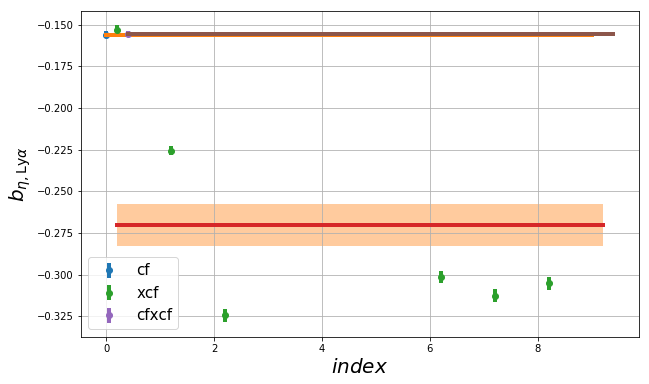

cf: <beta_LYA> = 1.2536714328024525 +/- 0.0 (<0.026591392229480666>, 0.026591392229480666)
xcf: <beta_LYA> = 14.798840563007003 +/- 2.550834065091321 (<1.0630189082716708>, 0.43397565203267163)
cfxcf: <beta_LYA> = 1.2537291920839024 +/- 0.0 (<0.021229193340451993>, 0.021229193340451993)


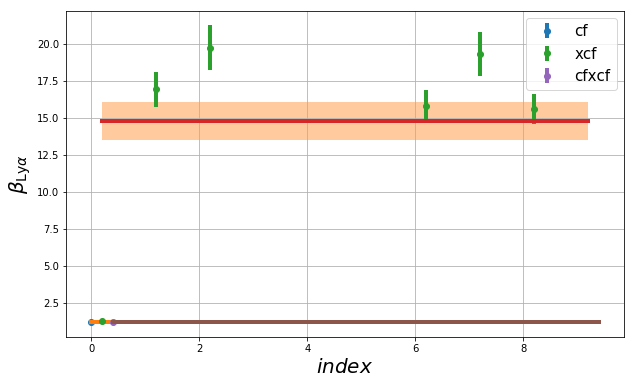

cfxcf: <beta_QSO> = 0.25417113220327137 +/- 0.0 (<0.0017148810899730146>, 0.0017148810899730146)


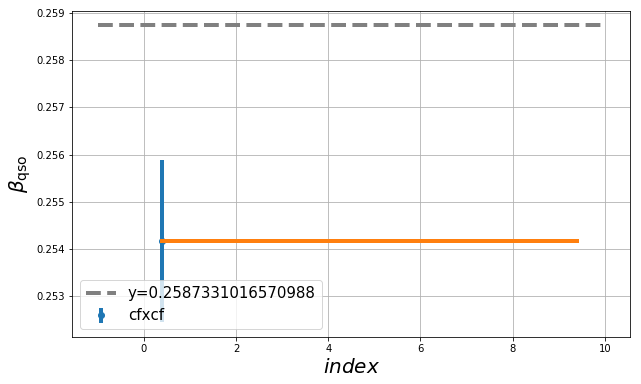

xcf: <sigma_velo_lorentz_QSO> = -1.9538499543070766 +/- 1.543481363647606 (<0.2280249415130298>, 0.09309079255581677)
cfxcf: <sigma_velo_lorentz_QSO> = -0.0006211906047980092 +/- 0.0 (<0.22486868168955723>, 0.22486868168955723)


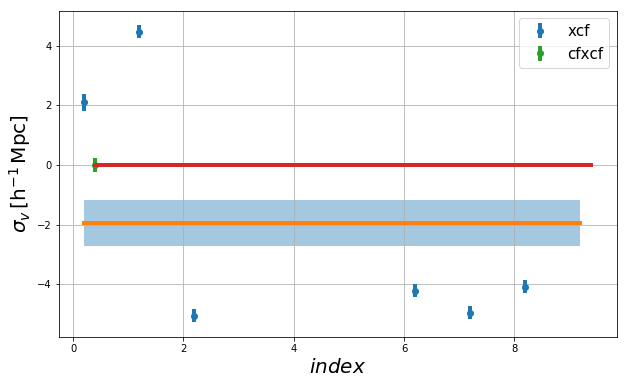

xcf: <drp_QSO> = 0.17135677904495142 +/- 0.026229233096618686 (<0.06985025934979477>, 0.028516248968011183)
cfxcf: <drp_QSO> = 0.04398431346808386 +/- 0.0 (<0.05325415478270961>, 0.05325415478270961)


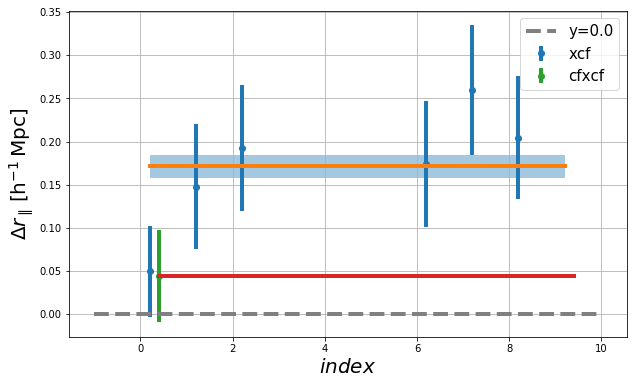

cf: <par_sigma_smooth> = 3.3263940083215195 +/- 0.0 (<0.09359318184322665>, 0.09359318184322665)
xcf: <par_sigma_smooth> = -0.0013103499666209265 +/- 0.0018476462115342672 (<0.6159560478466467>, 0.251463003534271)
cfxcf: <par_sigma_smooth> = 2.9934989025890877 +/- 0.0 (<0.07981984087706545>, 0.07981984087706545)


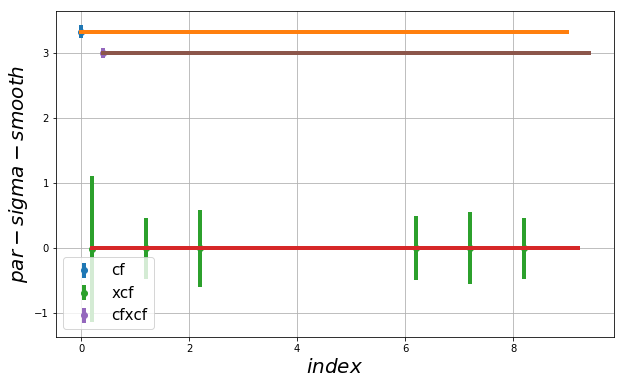

cf: <per_sigma_smooth> = 4.523403109938228 +/- 0.0 (<0.29024027710948275>, 0.29024027710948275)
xcf: <per_sigma_smooth> = 0.6347451904844469 +/- 0.6903292829127439 (<0.6488600142702021>, 0.2648959915761678)
cfxcf: <per_sigma_smooth> = 4.45195393272778 +/- 0.0 (<0.18792383064028698>, 0.18792383064028698)


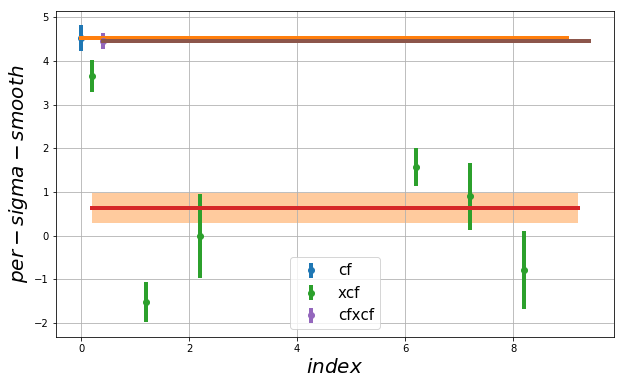

In [14]:
for p in latexname.keys():
    if not expected[p] is None:
        plt.plot(sp.arange(mock['nbReal']+2)-1.,expected[p]*sp.ones(mock['nbReal']+2),
                 '--',linewidth=4,color='grey',label='y={}'.format(expected[p]))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            if p=='sigma_velo_lorentz': yyy = sp.absolute(yyy)
            w = yer>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yyy[w],yerr=yer[w],fmt='o',label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
            print('{}: <{}> = {} +/- {} (<{}>, {})'.format(cor, p,mean,err,meanErr,meanErr/sp.sqrt(yyy[w].size)))
            plt.errorbar(xxx,mean*sp.ones(xxx.size))
            plt.fill_between( xxx, mean*sp.ones(xxx.size)-err/2., mean*sp.ones(xxx.size)+err/2.,alpha=0.4)
    plt.xlabel(r'$index$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The error as a function of mock index

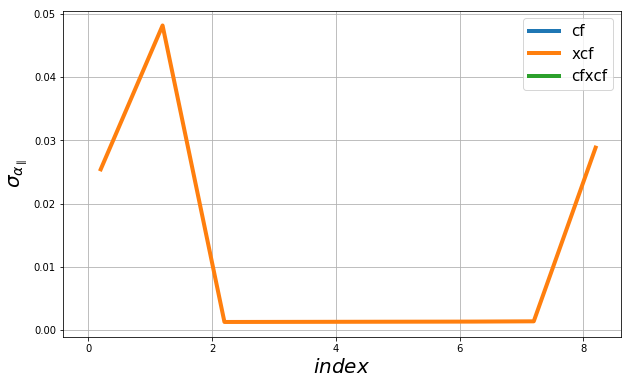

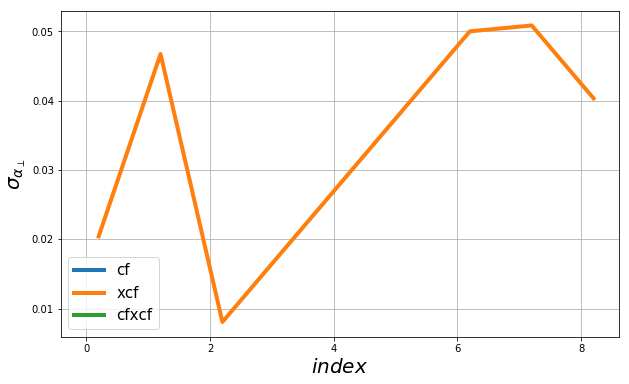

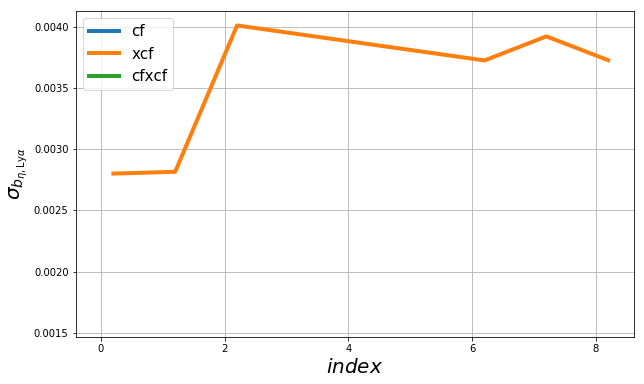

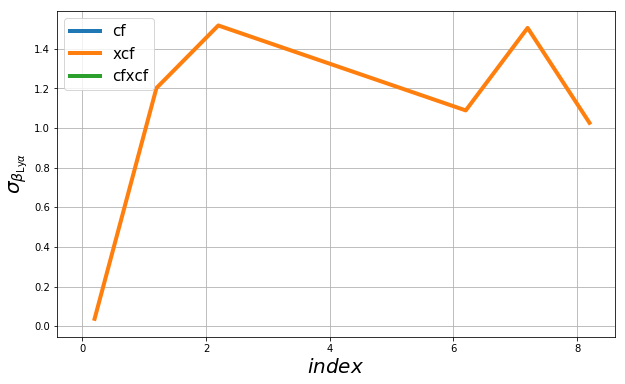

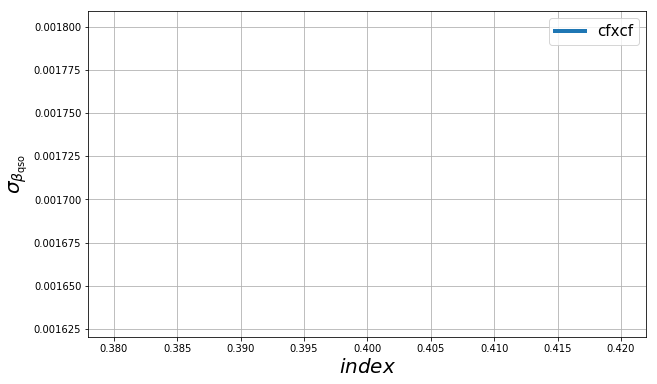

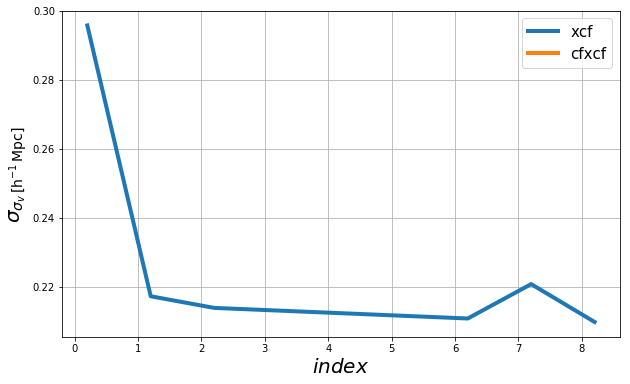

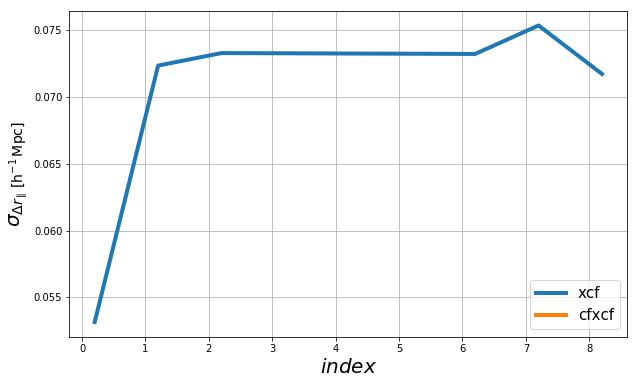

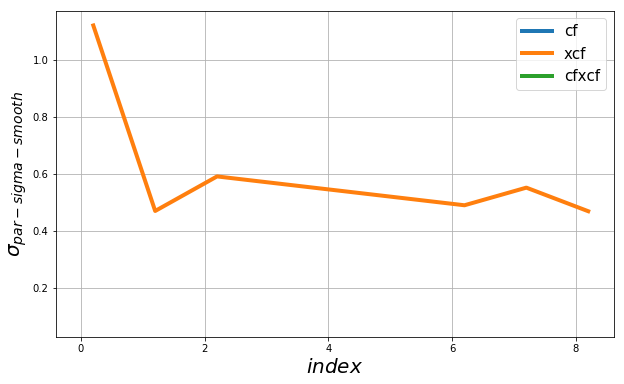

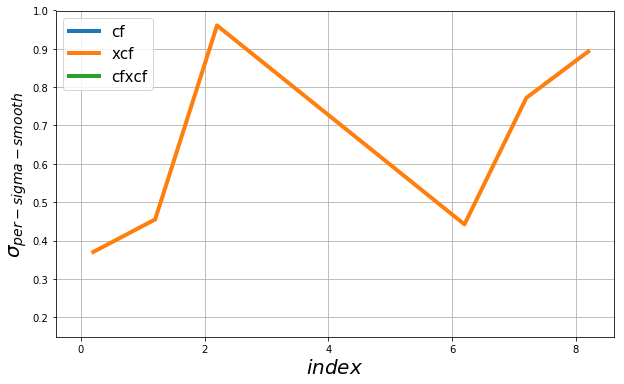

In [15]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            w = yer>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yer[w],label=cor)
    plt.xlabel(r'$index$')
    plt.ylabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The histograms of the parameters

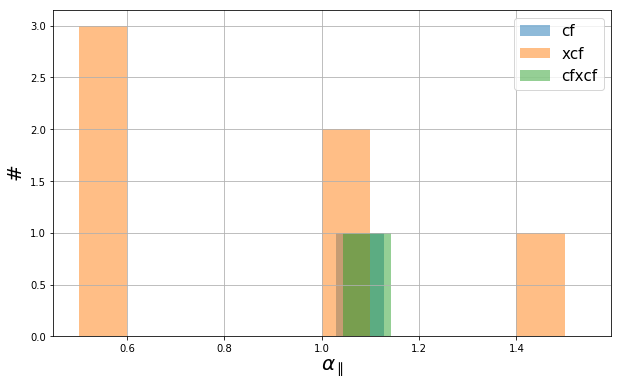

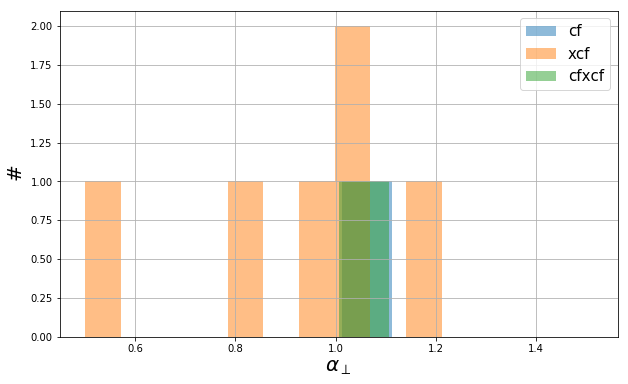

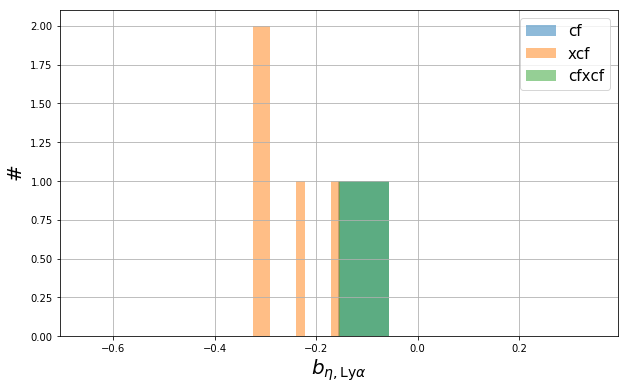

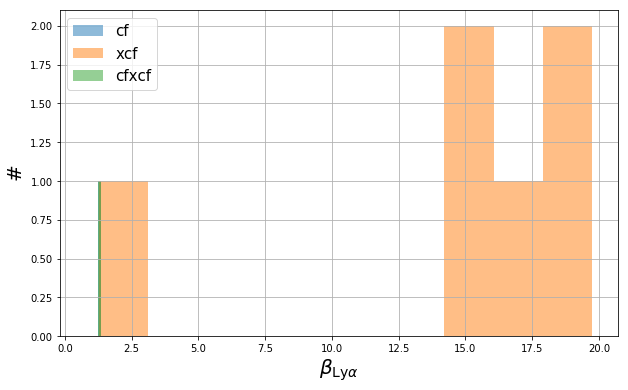

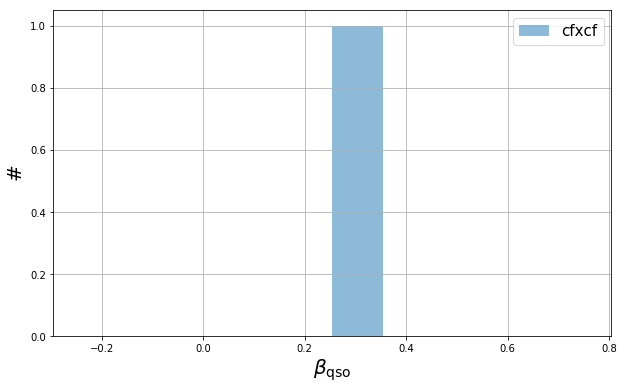

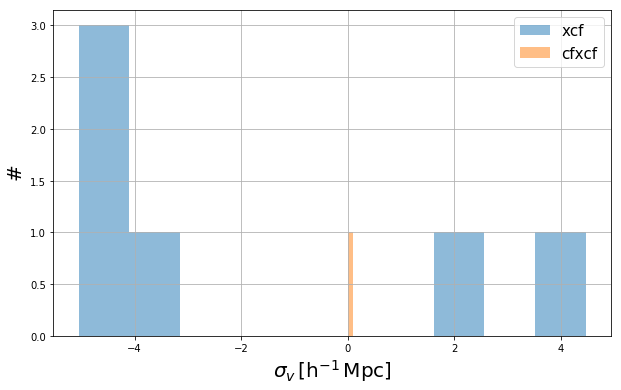

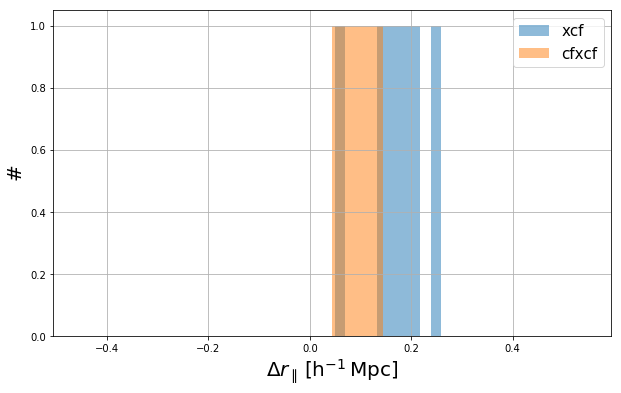

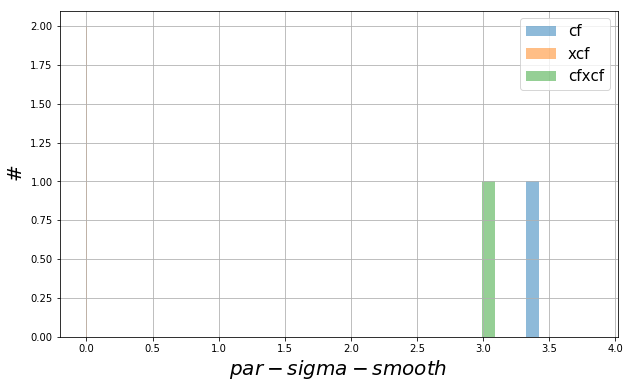

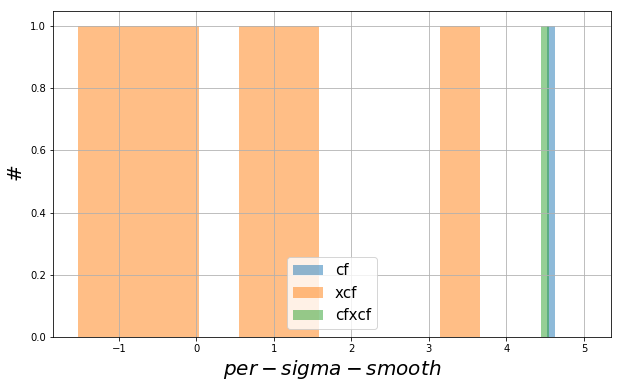

In [16]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,alpha=0.5,label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
    plt.xlabel(r'$'+latexname[p]+'$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Histogram of the errors

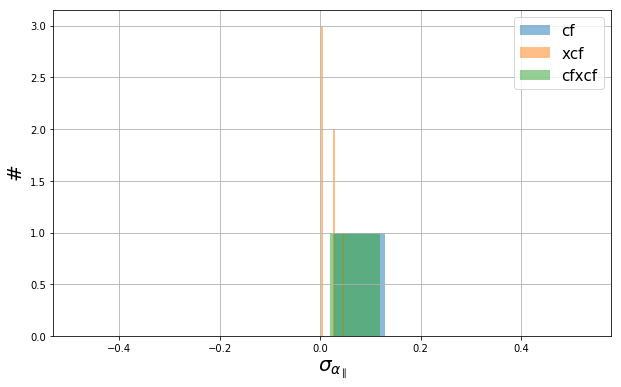

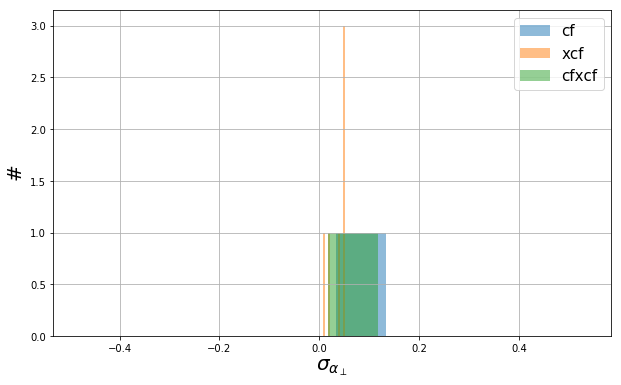

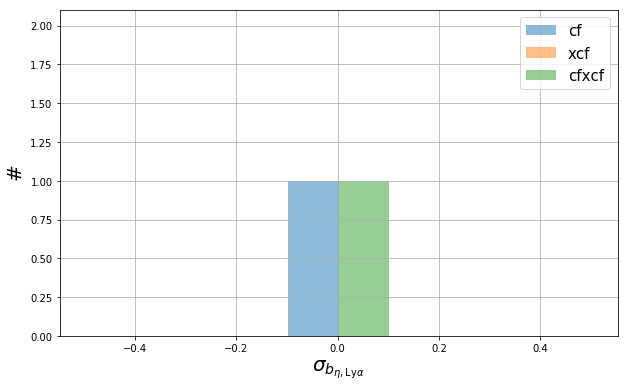

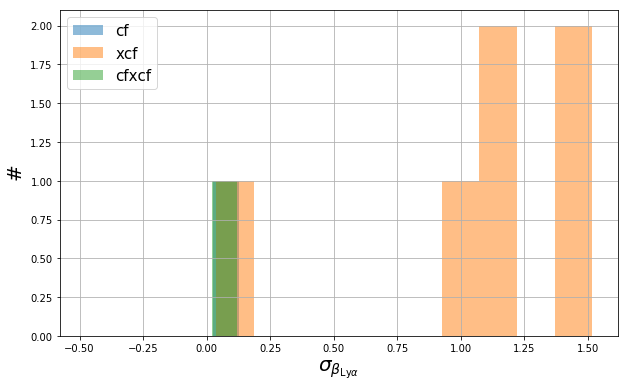

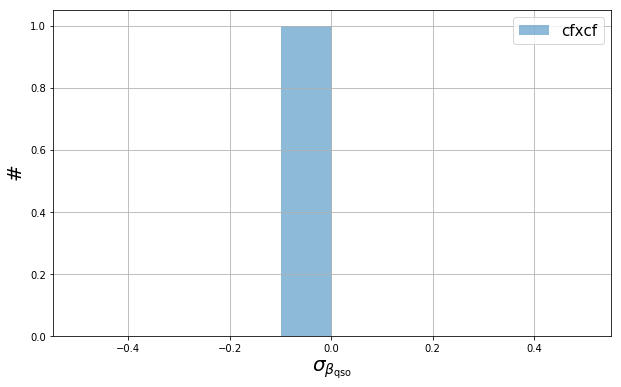

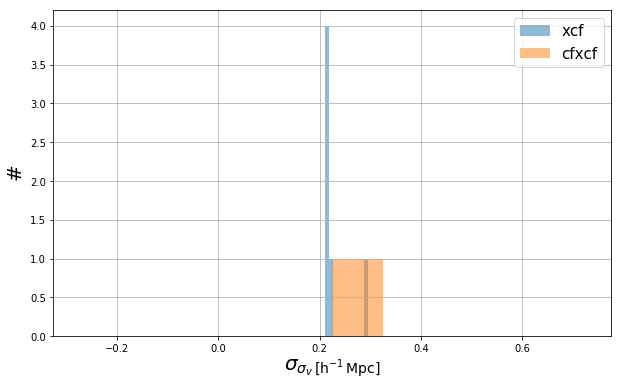

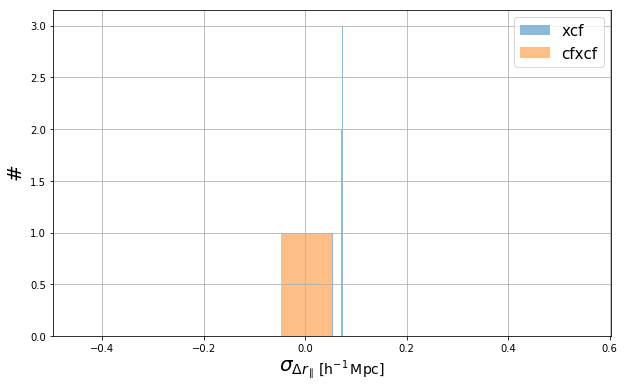

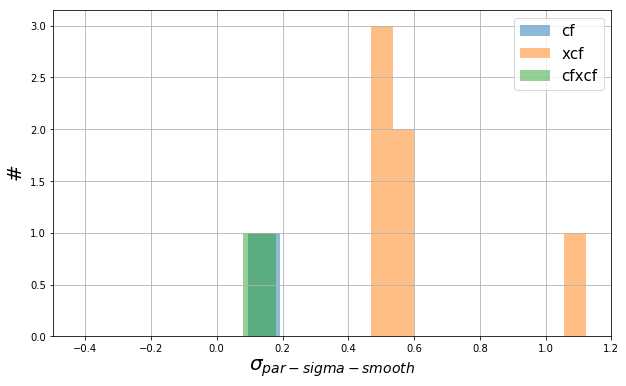

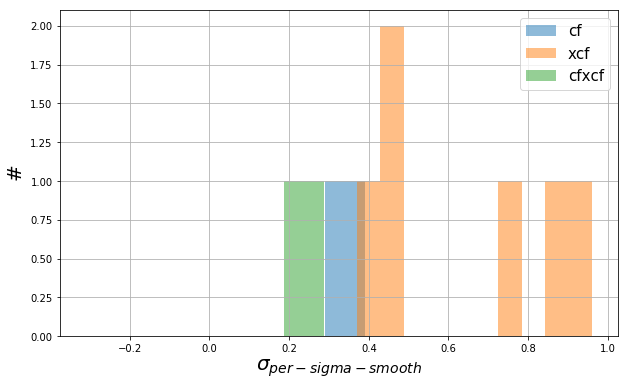

In [17]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf','allCombined']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yer[w],bins=10,alpha=0.5,label=cor)
    plt.xlabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The pull plots of the parameters

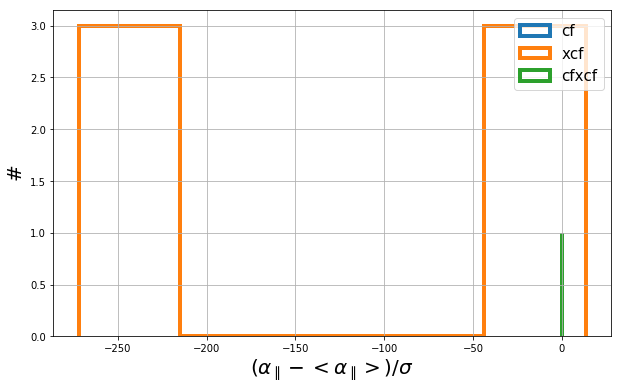

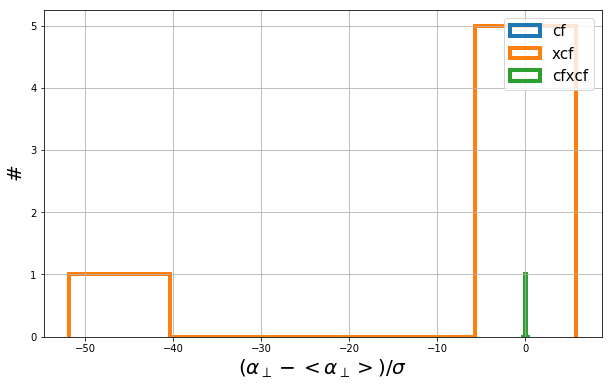

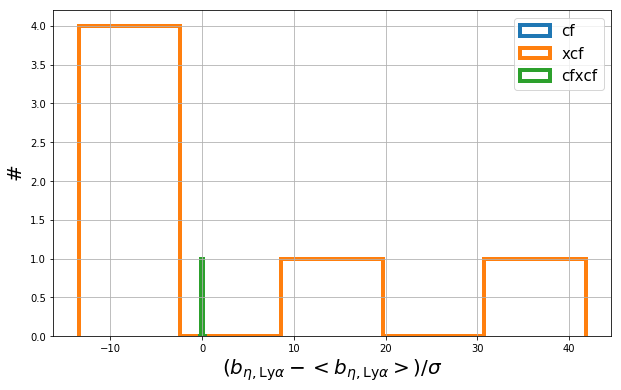

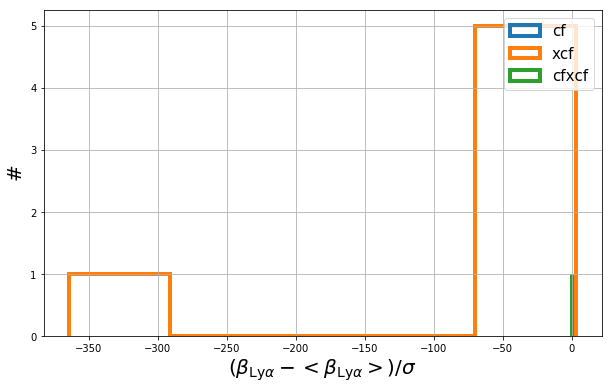

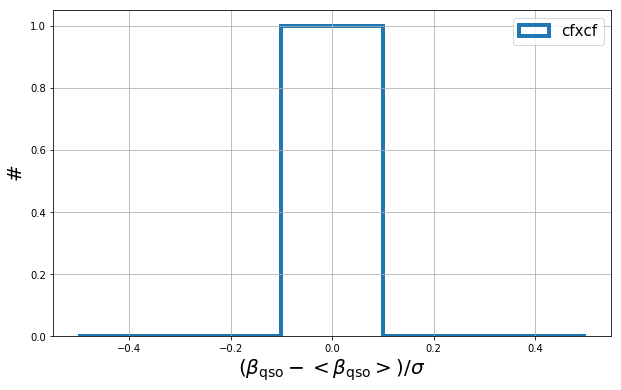

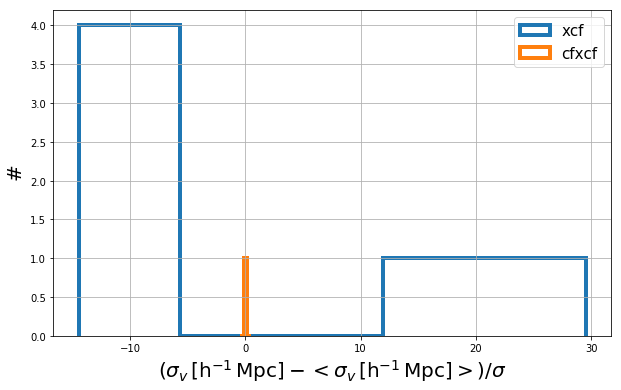

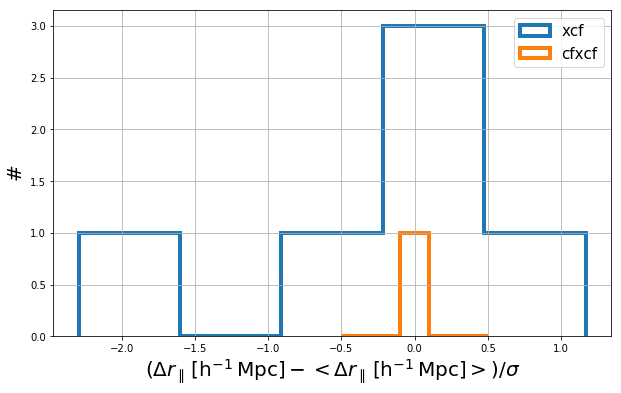

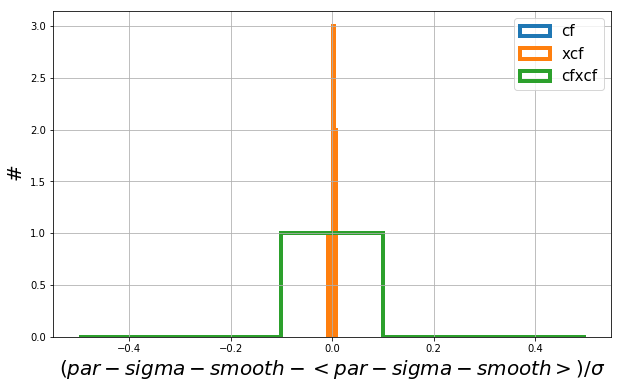

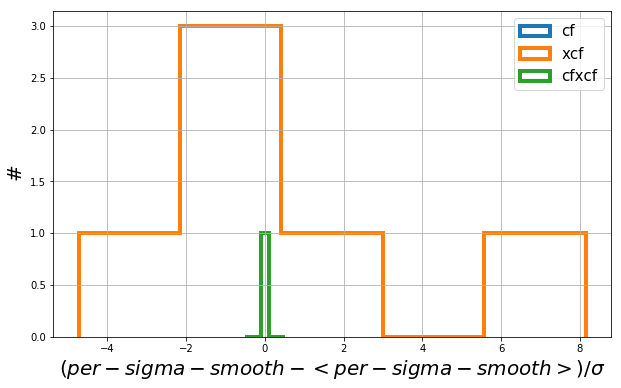

In [18]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist( (yyy[w]-yyy[w].mean())/yer[w] ,bins=5,label=cor,histtype='step',linewidth=4)
    plt.xlabel(r'$('+latexname[p]+'-<'+latexname[p]+'>)/\sigma$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Correlation between different parameters

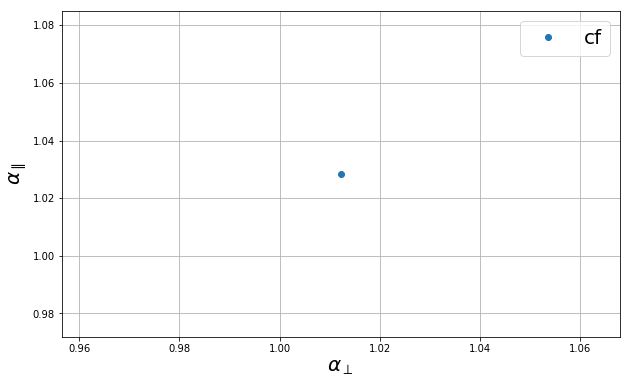

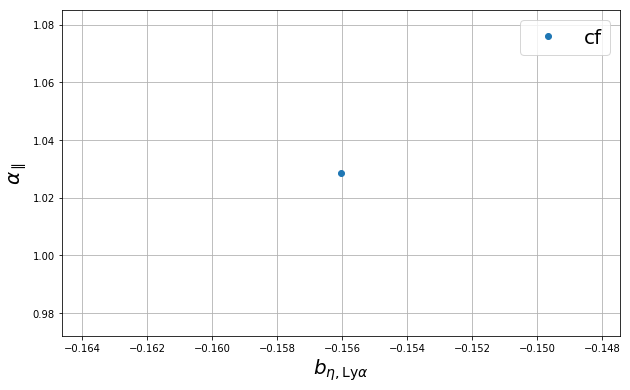

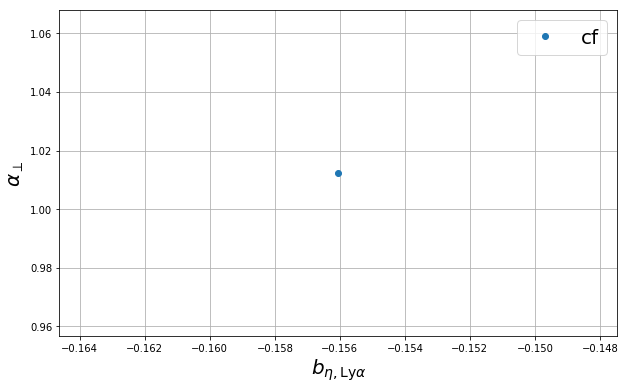

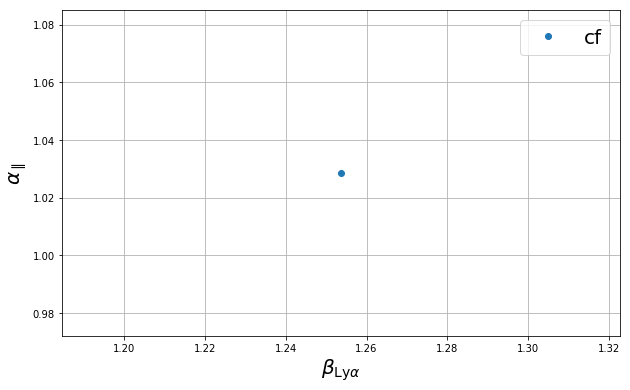

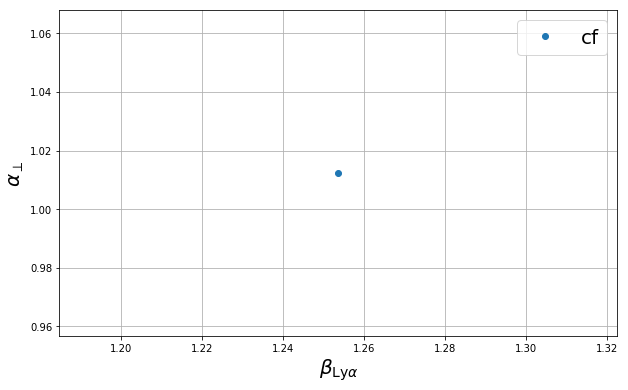

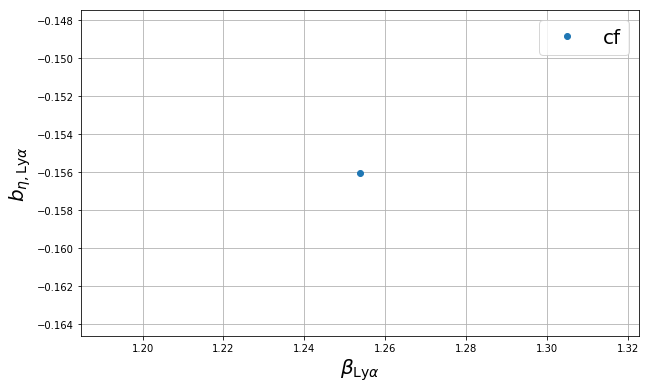

beta_QSO ap
beta_QSO at
beta_QSO bias_eta_LYA
beta_QSO beta_LYA
sigma_velo_lorentz_QSO ap
sigma_velo_lorentz_QSO at
sigma_velo_lorentz_QSO bias_eta_LYA
sigma_velo_lorentz_QSO beta_LYA
sigma_velo_lorentz_QSO beta_QSO
drp_QSO ap
drp_QSO at
drp_QSO bias_eta_LYA
drp_QSO beta_LYA
drp_QSO beta_QSO
drp_QSO sigma_velo_lorentz_QSO


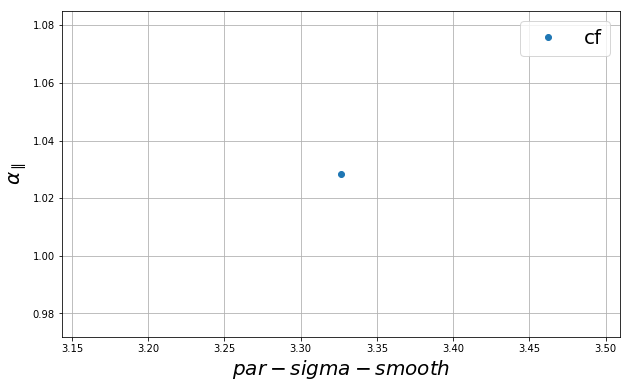

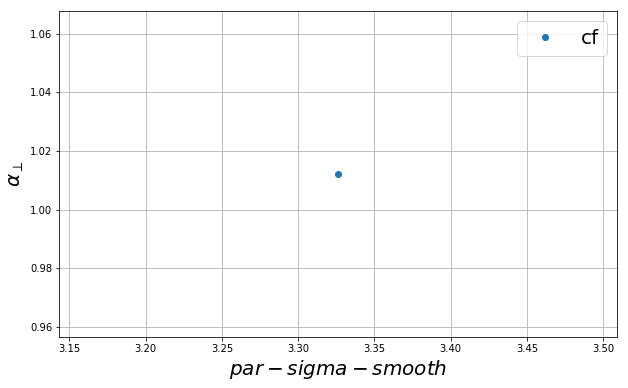

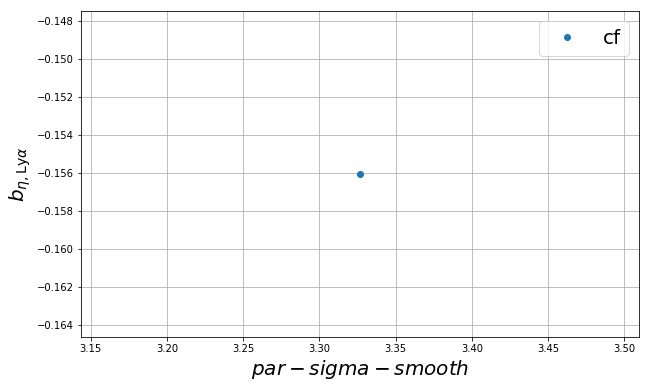

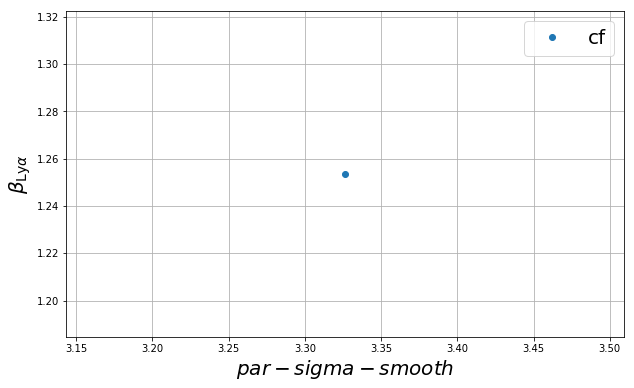

par_sigma_smooth beta_QSO
par_sigma_smooth sigma_velo_lorentz_QSO
par_sigma_smooth drp_QSO


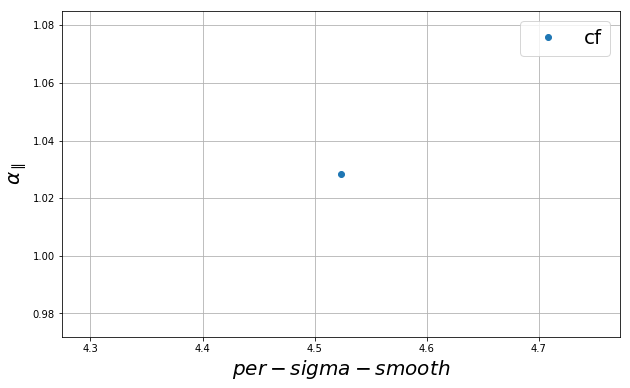

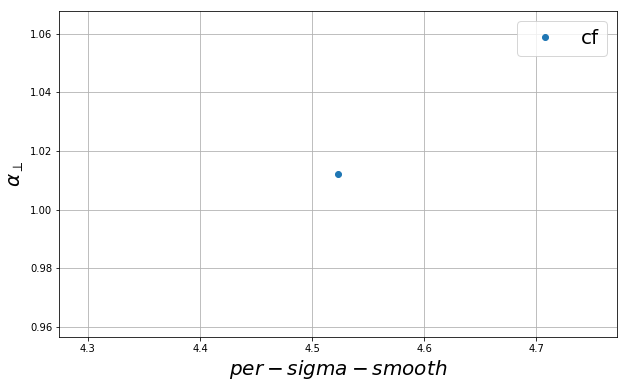

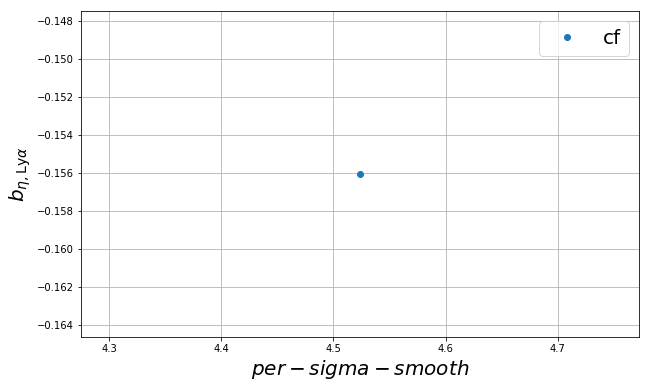

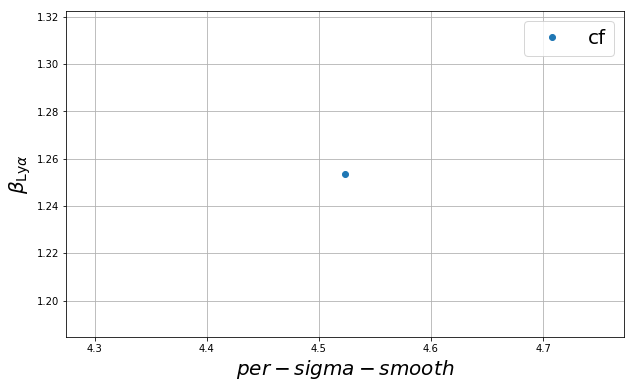

per_sigma_smooth beta_QSO
per_sigma_smooth sigma_velo_lorentz_QSO
per_sigma_smooth drp_QSO


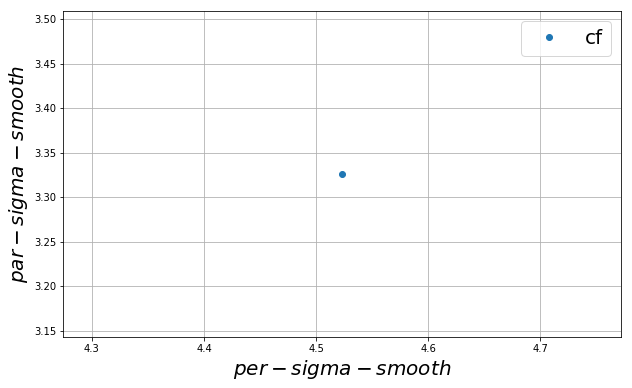

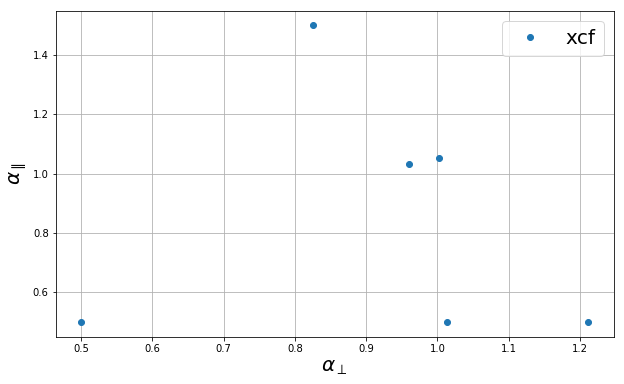

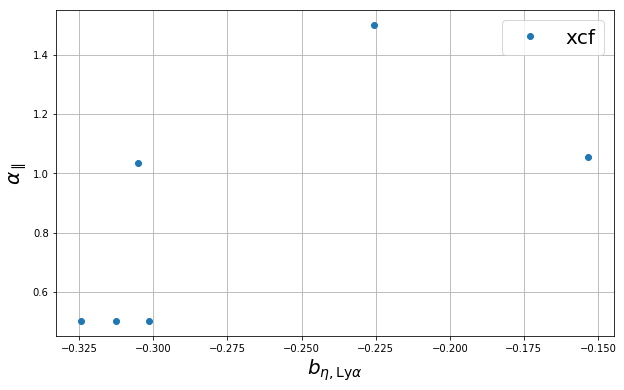

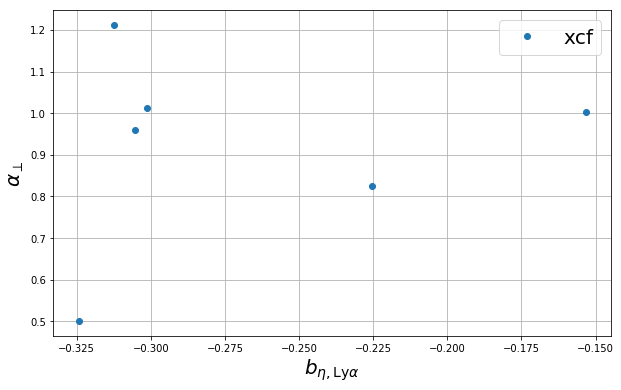

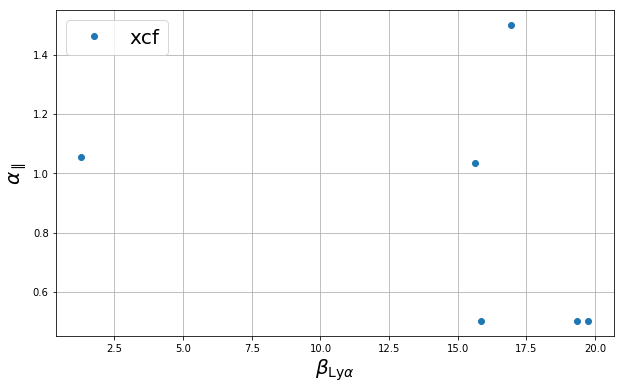

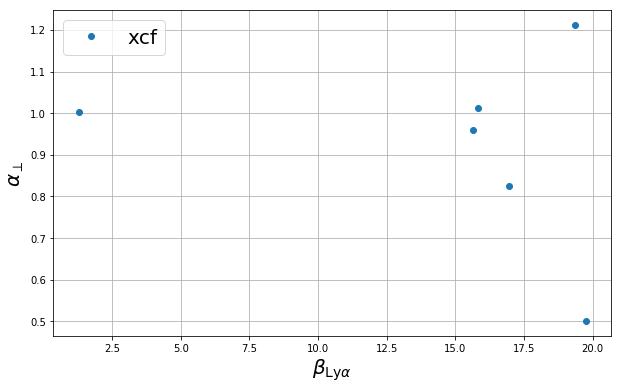

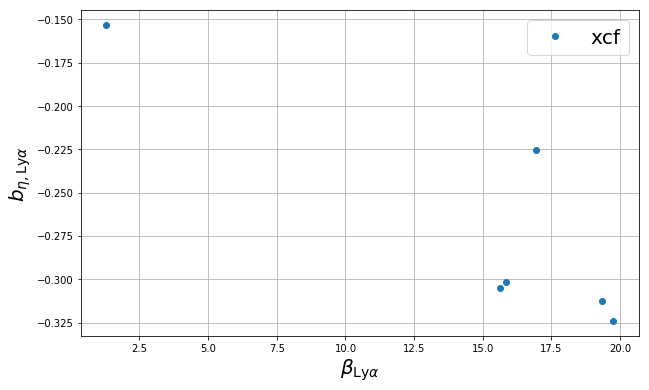

beta_QSO ap
beta_QSO at
beta_QSO bias_eta_LYA
beta_QSO beta_LYA


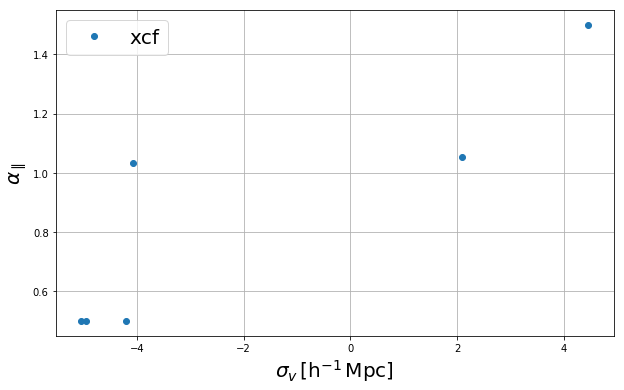

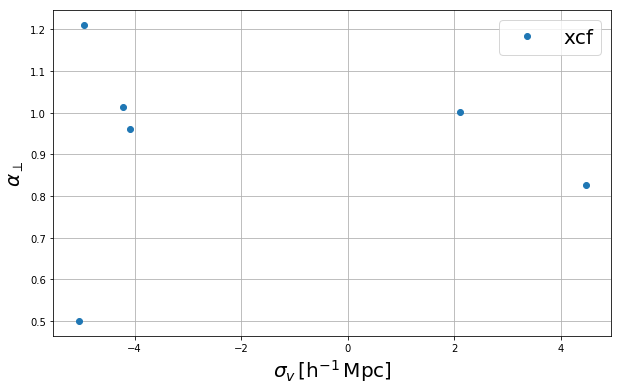

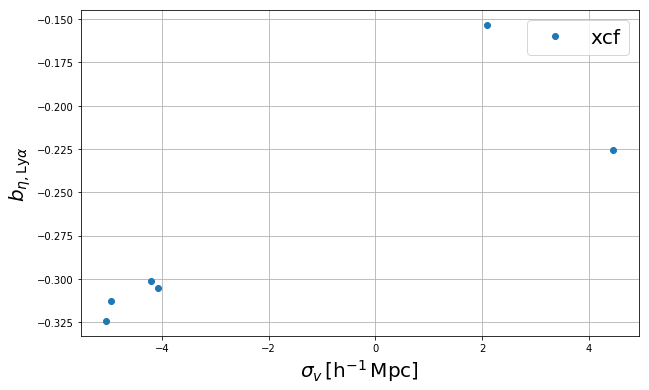

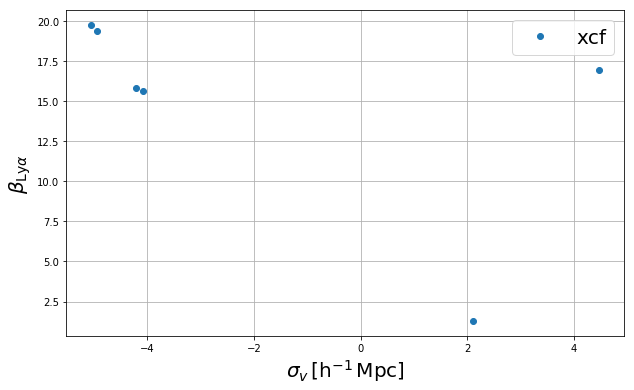

sigma_velo_lorentz_QSO beta_QSO


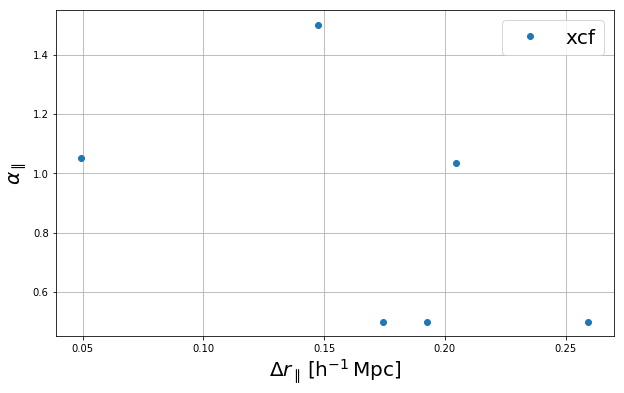

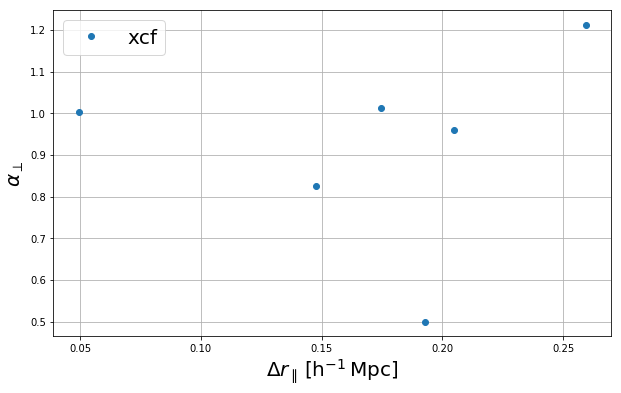

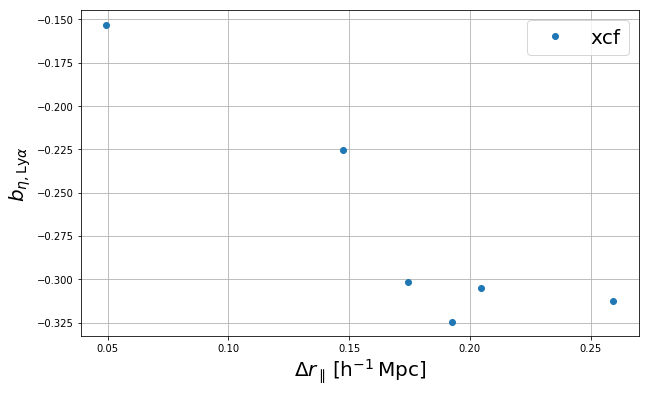

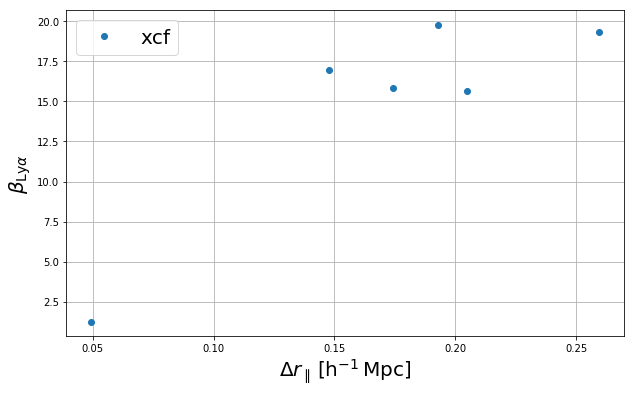

drp_QSO beta_QSO


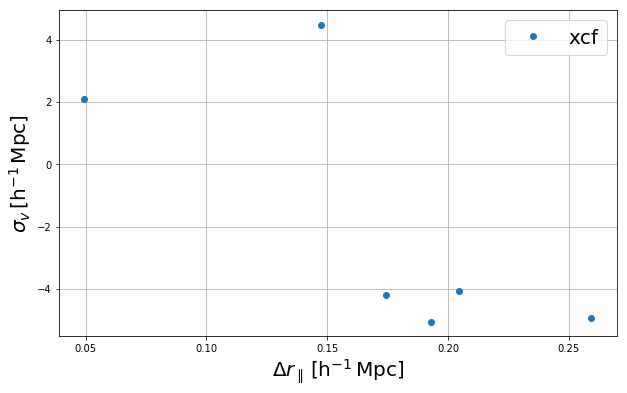

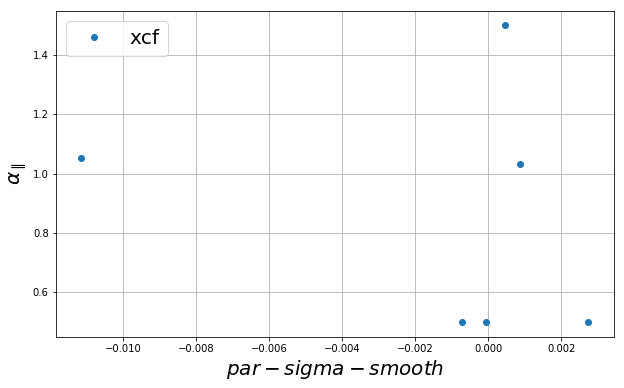

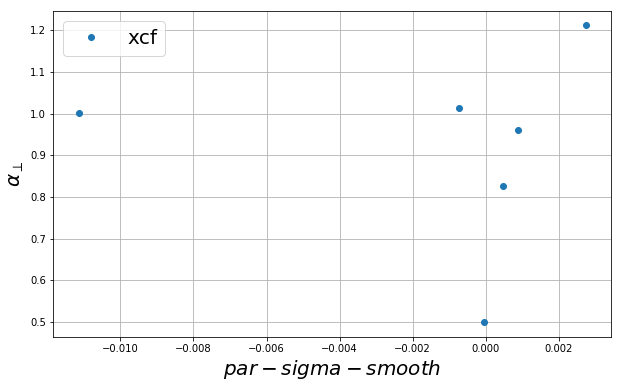

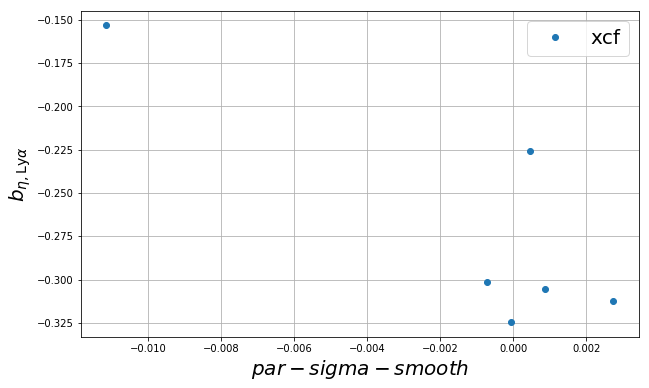

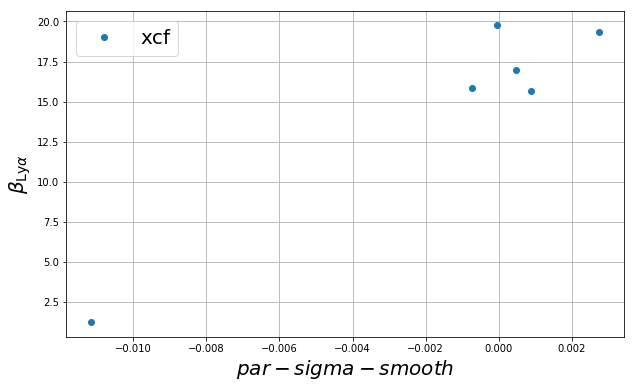

par_sigma_smooth beta_QSO


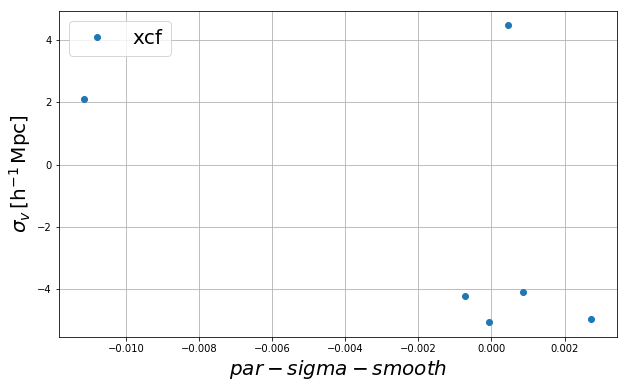

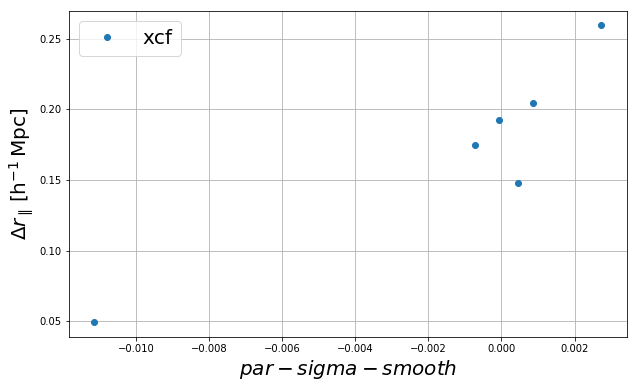

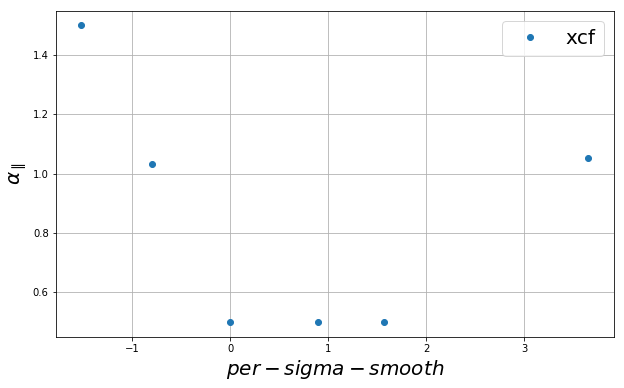

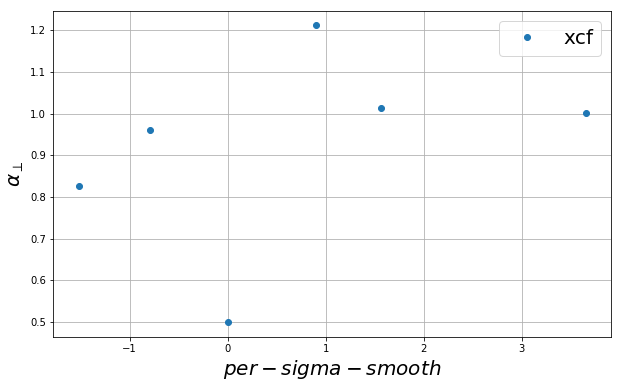

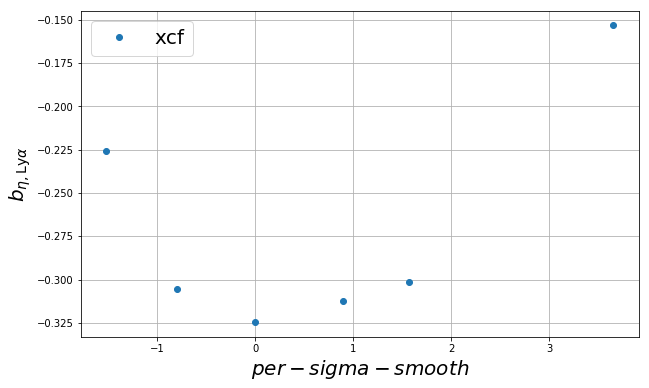

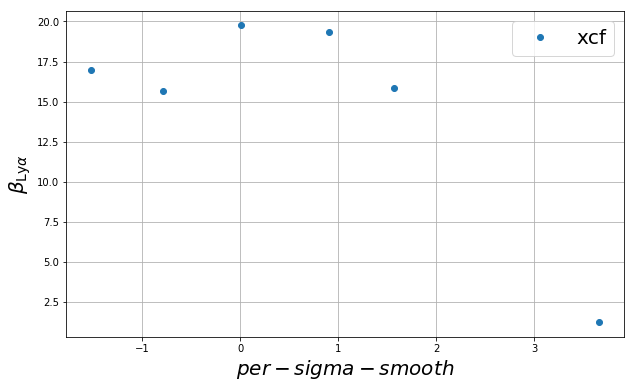

per_sigma_smooth beta_QSO


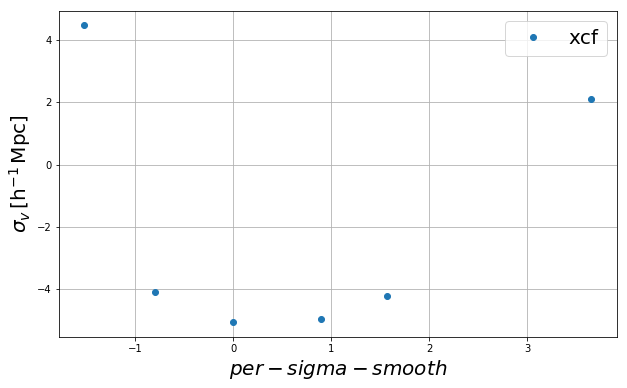

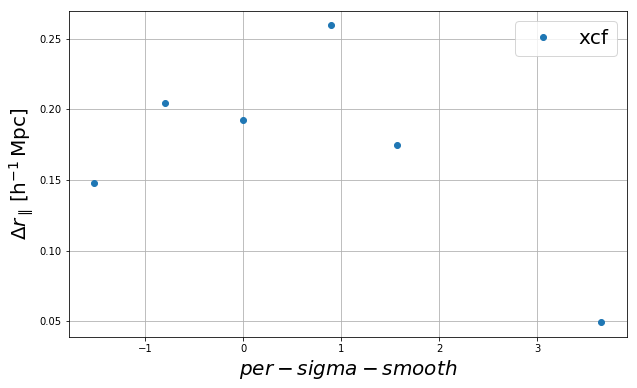

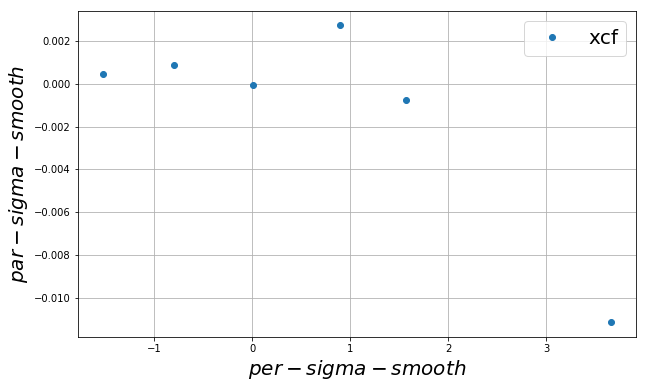

In [19]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    for cor in ['cf','xcf']:
        for i,p1 in enumerate(list(latexname.keys())):
            yyy = sp.zeros( (mock['nbReal'],2))
            yer = sp.zeros( (mock['nbReal'],2))
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p1 in toPlot[name]['FIT_RES']:
                    yyy[idx,0] = toPlot[name]['FIT_RES'][p1][0]
                    yer[idx,0] = toPlot[name]['FIT_RES'][p1][1]
            for p2 in list(latexname.keys())[:i]:
                if p1==p2: continue
                yyy[:,1] = 0.
                yer[:,1] = 0.
                for idx in range(mock['nbReal']):
                    name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                    if 'FIT_RES' in toPlot[name] and p2 in toPlot[name]['FIT_RES']:
                        yyy[idx,1] = toPlot[name]['FIT_RES'][p2][0]
                        yer[idx,1] = toPlot[name]['FIT_RES'][p2][1]
                w = (yer[:,0]>0.) & (yer[:,1]>0.)
                if w.sum()==0:
                    print(p1,p2)
                    continue
                plt.errorbar(yyy[w,0], yyy[w,1], fmt='o',label=cor)
                plt.xlabel(r'$'+latexname[p1]+'$')
                plt.ylabel(r'$'+latexname[p2]+'$')
                plt.legend()
                plt.grid()
                plt.show()

# __Mean correlation__

In [21]:
#fi = sorted(glob.glob(data['picca']+'/Correlations/Fit/xcf_z_*_noMet/result.h5'))
fi = sorted(glob.glob(mock['picca_all']+'/xcf_z*.h5'))
ff = h5py.File(fi[0],'r')
cosmo_pars = ['bias_LYA',"bias_eta_LYA","beta_LYA","bias_eta_QSO","beta_QSO","ap","at"]
all_pars = [p.decode('utf-8') for p in ff['best fit'].attrs['list of free pars']]
bname0 = fi[0].replace(".h5","")
ff.close()

print("{:20}".format(""),end="")
for f in fi:
    print("{:^20}".format(f.replace("-exp.h5","")),end="")
print("")

print("{:20}".format("zeff"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        zeff = ff['best fit'].attrs['zeff']
    except:
        print("PROBLEM: {}".format(f))
        continue
    out = "{}".format(round(zeff,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

for par in cosmo_pars:
    print("{:20}".format(par),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        if par in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[par]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
    
for par in all_pars:
    if par in cosmo_pars:
        continue
    print("{:20}".format(par[:20]),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        bname = f.replace(".h5","")
        pa = par.replace(bname0,bname)
        if pa in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[pa]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
print("{:20}".format("chi2/(ndata-npar)"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    out = "{}/({}-{})".format(round(chi2,1),ndata,npar)
    print("{:^20}".format(out),end="")
    ff.close()
print("")
print("{:20}".format("probability"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    proba = 1.-sp.stats.chi2.cdf(chi2,ndata-npar)
    out = "{}".format(round(proba,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

                    /project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-raw/stack/xcf_z_0_10
zeff                        2.3         
bias_LYA            
bias_eta_LYA          -0.21 +/- 0.001   
beta_LYA              2.934 +/- 0.019   
bias_eta_QSO            1.0 +/- 0.0     
beta_QSO               0.247 +/- 0.0    
ap                    1.028 +/- 0.011   
at                     1.004 +/- 0.01   
drp_QSO               0.102 +/- 0.024   
par_sigma_smooth      2.605 +/- 0.035   
per_sigma_smooth      -2.892 +/- 0.116  
sigma_velo_lorentz_Q  0.207 +/- 1.733   
chi2/(ndata-npar)     6738.2/(3180-8)   
probability                 0.0         


## __in 2d__

In [22]:
def convert1DTo2D(array1D,nbX,nbY):
    '''
        convert a 1D array to a 2D array
    '''

    array2D = sp.zeros(shape=(nbX,nbY))

    for k in range(array1D.size):
        i = k//nbY
        j = k%nbY

        array2D[i][j] = array1D[k]

    return array2D

In [23]:
ttoPlot = {}
ttoPlot['cf'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['xcf'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

In [24]:
power = 1
for name,paths in sorted(ttoPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    r = convert1DTo2D(r,np,nt)
    da = convert1DTo2D(da,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    da[er==0.] = float('nan')
    if name=='cf':
        origin='lower'
        extent = [rt_min, rt_max, rp_min, rp_max]
    elif name=='xcf':
        origin='upper'
        extent=[rt_min, rt_max, rp_max, rp_min]
    plt.imshow(da*r**power, origin=origin,extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(name+'\,:\,'+paths['TITLE'])
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$r\xi(\, r_{\parallel},r_{\perp} \,)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

OSError: File not found: '/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-raw/stack//cf_z_0_10-exp.fits'

## __variance__

In [25]:
zmin = 0
zmax = 10
for cor in ['cf','xcf']:
    for idx in range(mock['nbReal']):
        tpath = mock['picca'].replace('<*>',str(idx))+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax)
        h = fitsio.FITS(tpath)
        if idx==0:
            co = h[1]['CO'][:].copy()
            nb = 1.*h[1]['NB'][:].copys()
        else:
            co += h[1]['CO'][:]
            nb += h[1]['NB'][:]
        h.close()
    co /= mock['nbReal']
    nb /= mock['nbReal']

    ###
    plt.plot(sp.diag(co)*nb,label=r'$\mathrm{'+cor+'}$')
    plt.xlabel(r'$index$')
    plt.ylabel(r'$C_{AA}N_{b}$')
    plt.legend()
    plt.grid()
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'copys'

In [26]:
ttoPlot = {}
ttoPlot['cf'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['xcf'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

base = 'cf_z_0_10'
ttoPlot['Data-cf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}

base = 'xcf_z_0_10'
ttoPlot['Data-xcf'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}

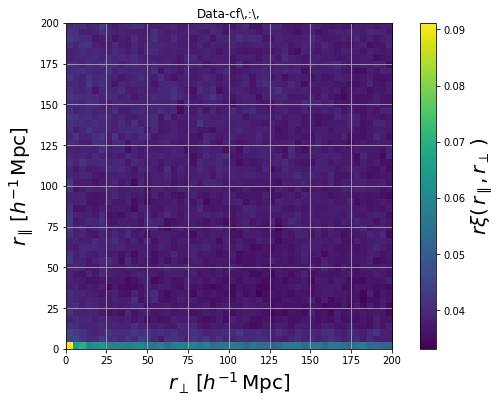

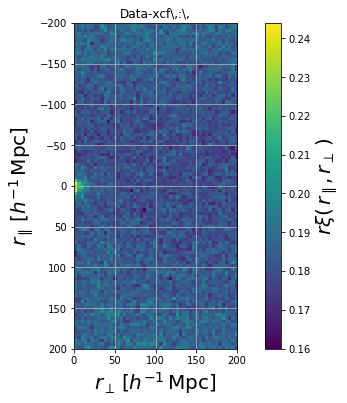

OSError: File not found: '/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-raw/stack//cf_z_0_10-exp.fits'

In [27]:
power = 0
for name,paths in sorted(ttoPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    np = h[1].read_header()['NP']
    nt = h[1].read_header()['NT']
    rt_min = 0.
    rt_max = h[1].read_header()['RTMAX']
    rp_min = h[1].read_header()['RPMIN']
    rp_max = h[1].read_header()['RPMAX']
    r = sp.sqrt( h[1]['RP'][:]**2 + h[1]['RT'][:]**2 )
    nb = h[1]['NB'][:]
    da = h[1]['DA'][:]
    co = h[1]['CO'][:]
    r = convert1DTo2D(r,np,nt)
    nb = convert1DTo2D(nb,np,nt)
    er = convert1DTo2D(sp.diag(co),np,nt)
    er[er==0.] = float('nan')
    if 'xcf' in name:
        origin='upper'
        extent=[rt_min, rt_max, rp_max, rp_min]
    elif 'cf' in name:
        origin='lower'
        extent = [rt_min, rt_max, rp_min, rp_max]
    plt.imshow(er*nb*r**power, origin=origin,extent=extent, interpolation='nearest')
    cbar = plt.colorbar()
    plt.title(name+'\,:\,')
    plt.xlabel(r'$r_{\perp} \, [h^{-1} \, \rm{Mpc}]$')
    plt.ylabel(r'$r_{\parallel} \, [h^{-1} \, \rm{Mpc}]$')
    cbar.set_label(r'$r\xi(\, r_{\parallel},r_{\perp} \,)$')
    plt.grid(True)
    cbar.update_ticks()
    plt.show()

# Wedge plots

In [28]:
ttoPlot = {}
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])

In [29]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=2)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

OSError: File not found: '/project/projectdirs/desi/mocks/lya_forest/picca/london/v6.0/global/eboss-raw/stack//cf_z_0_10-exp.fits'

In [32]:
ttoPlot = {}
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

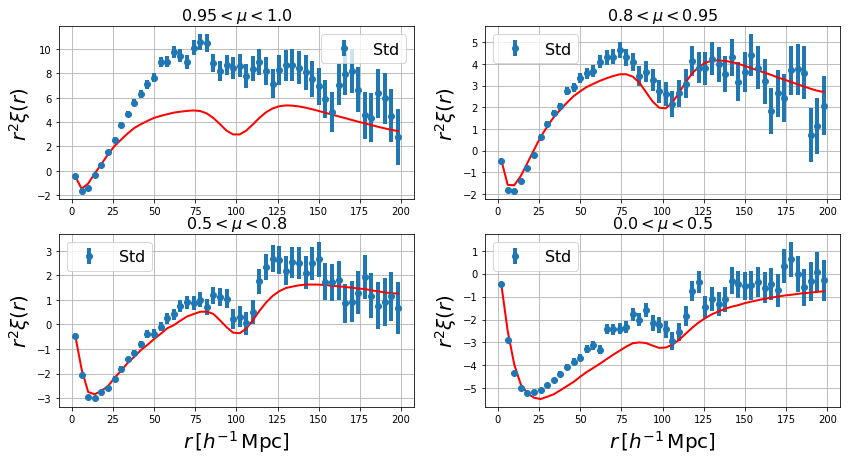

In [33]:
mus = [1., 0.95, 0.8, 0.5, 0.]
power = 2
f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i,(mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",label=r'$\mathrm{'+name+'}$')
        axs[i//2][i%2].plot(r,f*r**power,color='red',linewidth=2)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

# Slice plots

In [ ]:
ttoPlot = {}
ttoPlot['Mock'] = toPlot['all-Mock-xcf-z-0-10']

In [ ]:
slices = [0]
for s in slices:
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
ttoPlot = {}
for idx in range(mock['nbReal']):
    ttoPlot[str(idx)] = copy.deepcopy(toPlot['{}-Mock-{}-z-{}-{}'.format(idx,'cf','0','10')])
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])

if data['forest']=='LYA':
    base = 'cf_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

In [ ]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        elif name=='Data':
            axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{Data}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        else:
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

In [ ]:
ttoPlot = {}
for idx in range(mock['nbReal']):
    ttoPlot[str(idx)] = copy.deepcopy(toPlot['{}-Mock-{}-z-{}-{}'.format(idx,'xcf','0','10')])
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    ttoPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

In [ ]:
mus = [1., 0.95, 0.8, 0.5, 0.]

f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        if name=='Std':
            axs[i//2][i%2].errorbar(r,d*r**2,fmt="o",label=r'$\mathrm{Stack}$',color='blue')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        elif name=='Data':
            axs[i//2][i%2].errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label=r'$\mathrm{Data}$',color='black')
            axs[i//2][i%2].plot(r,f*r**2,color='red',linewidth=1)
        else:
            alpha = 0.2
            axs[i//2][i%2].errorbar(r,d*r**2,color='blue',alpha=alpha)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

## __bias of QSO__

In [ ]:
def alpha(z,a0,a1,zeff=2.30):
    evol = a0*((1.+z)/(1.+zeff))**a1
    return evol
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0=0.315):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

In [ ]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4,label='evol fit data',color='grey')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
w = biasCoLoRe[:,0]>1.5
plt.plot(biasCoLoRe[:,0][w],betaCoLoRe[w],linewidth=4,label='evol CoLoRe',color='orange')

for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst if ('beta_QSO' in el.keys())])
    yyy = sp.array([ el['beta_QSO'][0] for el in lst if ('beta_QSO' in el.keys()) ])
    zzz = sp.array([ el['beta_QSO'][1] for el in lst if ('beta_QSO' in el.keys()) ])
    w = zzz>0.
    if w.sum()==0: continue
    plt.errorbar(xxx[w],yyy[w],zzz[w],fmt='o')

### (Mock) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name)
       and (not '0-10' in name) and ('FIT_RES' in vals.keys())]
xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
#plt.errorbar(xxx,yyy,err,fmt='o',color='black',label='Mock')

### (Data) Fit the evolution
#cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
#xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
#yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
#err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
#plt.errorbar(xxx,yyy,err,fmt='o',color='green',label='Data')

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
#plt.xlim([2.3,2.32])
#plt.ylim([0.24,0.27])
plt.grid()
plt.show()